# **Contexto A: Control de Calidad Industrial**

## PARTE 1: CNN

### CARGA DE DATOS

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Imágenes de Entrenamiento: 51000
Imágenes de Validación: 9000
Imágenes de Test: 10000


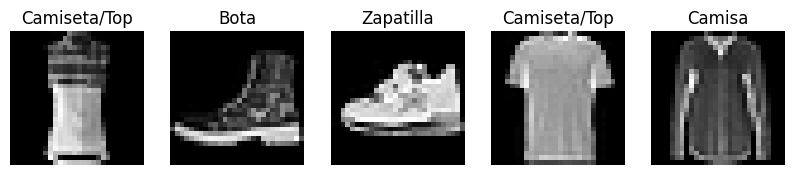

In [6]:
#1. Importamos las librerias y funcionalidades necesarias
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split # para crear el split manualmente

#Configuracion basica
batch_size = 32
random_seed = 42

#fijamos la semila de aletoriedad para las operaciones de Tensorflow y en numpy
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

#2. Carga de datos y division en subconjuntos
# Separamos los conjuntos directamente en validacion y test: Train y test ya vienen separados por defecto
(x_train_full, y_train_full), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalización y Reshape
# Normalizamos convirtiendo los píxeles de 0-255 a 0-1 dividiendo entre 255
x_train_full = x_train_full.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train_full = x_train_full.reshape(-1, 28, 28, 1) # damos formato (28, 28, 1), es decir, 28 alto, 28 ancho y 1 en color porque tenemos escala de grises
x_test = x_test.reshape(-1, 28, 28, 1)

# Crear el conjunto de validacion
# El dataset nos da 60k train y 10k test, por lo que sacamos el 15% de train para la validacion (son unas 9000 fotos)
x_train, x_val, y_train, y_val = train_test_split(
    x_train_full, y_train_full,
    test_size=0.15,
    random_state=random_seed
)

# Etiquetas de visualización: basadas en la documentación oficial traducida
class_names = ['Camiseta/Top', 'Pantalon', 'Jersey', 'Vestido', 'Abrigo',
               'Sandalia', 'Camisa', 'Zapatilla', 'Bolso', 'Bota']
# Prints al estilo de la profesora
print(f"Imágenes de Entrenamiento: {len(x_train)}")
print(f"Imágenes de Validación: {len(x_val)}")
print(f"Imágenes de Test: {len(x_test)}")

# Visualización
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    # Quitamos la dimensión del canal (el 1) para poder pintar
    plt.imshow(x_train[i].reshape(28, 28), cmap='gray')
    plt.title(class_names[y_train[i]]) # Ponemos la etiqueta segun nuestra lista anterior
    plt.axis('off')
plt.show()

Esta fase lo que hemos hecho ha sido llevar a cabo la carga de datos verificando el balenceo de muestras e iterando sobre las etiquetas del dataset para su clasificación.

Fijamos el número de semillas aleatorias para que la división de datos sea igual en cada ejecución.

Hemos utilizado el dataset Fashion-MNIST, con imágenes de 28x28 píxeles en escala de grises distribuidas en 10 categorías de ropa (ver fuente de las categorías de las imágenes).
- Hemos llevado a cabo una normalización de los valores de intensidad de los píxeles a (0,1). Para ello, dividimos entre 255 para que las funciones de activación funcionen mejor, pues cuando los números están en un rango uniforme, los optimizadores (GSD) avanzan de manera más suave y consistente.
- Hemos añadido el canal del color (1) en keras

La estrategia de división ha sido dividir en entrenamiento y test de manera inicial (el test solo se usará al final como evaluación). Después, el conjunto de entrenamiento se ha dividido en un subconjunto de validación del 15% que será el que prueben todas las redes al final de cada época.

Fuente documentación oficial etiquetas de imágenes: https://github.com/zalandoresearch/fashion-mnist

## Diseño y Construcción de la Arquitectura (RAAP)

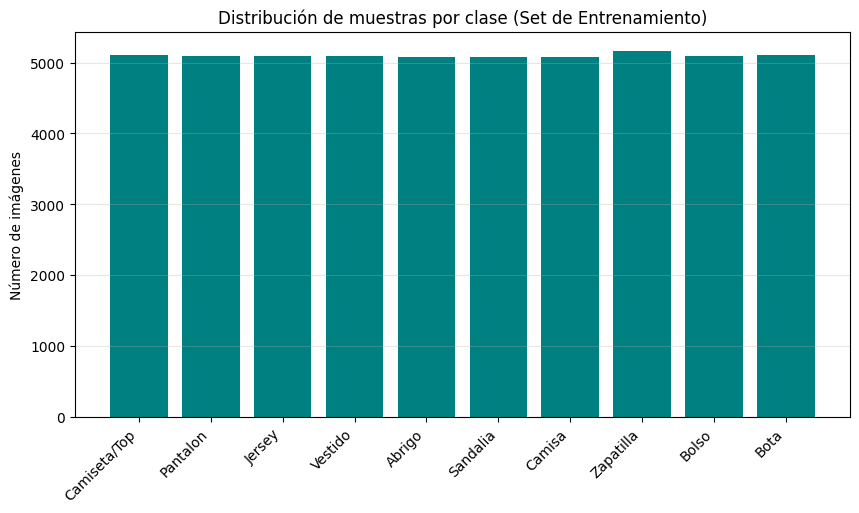

In [ ]:
# 3. Análisis de distribución de clases
plt.figure(figsize=(10, 5))

# Creamos el histograma usando y_train con nuestra lista de etiquetas
counts, bins, patches = plt.hist(y_train,
                                 bins=np.arange(len(class_names) + 1) - 0.5,
                                 rwidth=0.8,
                                 color='teal')

plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
plt.title("Distribución de muestras por clase (Set de Entrenamiento)")
plt.ylabel("Número de imágenes")
plt.grid(axis='y', alpha=0.3)

plt.show()

En este gráfico, podemos observar que la distribución de clases en el set de entrenamiento está equilibrada y, por tanto, tenemos un dataset de entrenamiento balanceado. Así, evitamos sesgo de clases y podemos utilizar la métrica Accuracy para medir el rendimiento global, ya que nuestros datos no están desbalanceados.

In [ ]:
#4. Optimizacion de datos

# Convertimos los arrays de Numpy a tensores de TensorFlow
ds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((x_val, y_val))
ds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Pipeline de entrenamiento - ds_train
ds_train = ds_train.cache() # CACHE: Guardamos en memoria para eficiencia
ds_train = ds_train.shuffle(buffer_size=1000) # SHUFFLE: Mezclamos en entrenamiento para romper patrones de orden (buffer de 1000 imágenes para mezclar)
ds_train = ds_train.batch(batch_size) # Batch: Agrupamos las fotos en paquetes de 32 definido al principio
ds_train = ds_train.prefetch(tf.data.AUTOTUNE) # PREFETCH: Mientras la GPU entrena un batch, la CPU prepara el siguiente

# Pipeline de vaidacion - ds_val
# No hacemos suffle porque mantenemos el orden

ds_val = ds_val.cache()
ds_val = ds_val.batch(batch_size)
ds_val = ds_val.prefetch(tf.data.AUTOTUNE)

# Pipeline de test - ds_test
# No hacemos cache porque solo lo usamos una vez

ds_test = ds_test.batch(batch_size)
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

Hemos llevado a cabo una estrategia de optimización de datos para trabajar las redes neuronales.

En primer lugar, hemos transformado los array de NumPy en objetos tf.data.Dataset para poder utilizar funciones de la librería TensorFlow.

Después, hemos utilizado tres conceptos clave: CACHE, SHUFFLE y PREFETCH.
- **CACHE**: cache() guarda el dataset preprocesado en memoria tras la primera epoch, de manera que no tenemos que leer las imágenes del disco en cada epoch, acelerando así el proceso de entrenamiento.
- **SHUFFLE**: esta función mezcla aleatoriamente las muestras antes de cada epoch, evitando así que el modelo vea los datos siempre en el mismo orden y pueda aprender patrones falsos. Utilizamos 1000 debido a que es un número lo suficientemente grande para garantizar la variedad de clases sin provocar problemas en la memoria RAM.
- **PREFETCH**: sirve para solapar el preprocesado de datos con el entrenamiento de manera que la GPU no tenga que esperar. Así, mientras la GPU entrena con un batch, prepara el siguiente en paralelo. Se utiliza AUTOTUNE para que TensorFlow elija automáticamente el número óptimo de batches que debe preparar por adelantado.

Por último, es importante comentar que agrupamos las imágenes en lotes de 32 mediante el bacth_size definido al principio. Así, optamos por un entrenamiento basado en **Mini-Batch** Gradient Descent que es un estándar por ser potencia de 2. Es lo suficientemente pequeño para introducir algo de ruido que ayuda a escapar de mínimos locales y lo suficientemente grande para estimar el gradiente de forma estable.

In [ ]:
# 5. Definición del modelo CNN

num_classes = 10

model = models.Sequential([
    # Capa 1: Extraccion de bordes y texturas simples
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
    layers.MaxPooling2D((2,2)), # reduce la imagen

    # Capa 2: Extracción de patrones complejos
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)), # reduce la imagen otra vez

    # Aplanado
    # Convierte el mapa de características 3D en un vector largo 1D
    layers.Flatten(),

    # Clasificación
    layers.Dense(64, activation='relu'),

    # Capa de salida: 10 neuronas (una por clase)
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

En cuanto al modelo CNN definido, esta ha sido su arquitectura (las decisiones sobre los parámetros se explicarán después):
1. Dos capas de convolución:
- Primera capa (32 filtros, 3x3): se encarga de extraer características simples como los bordes o las esquinas de las prendas.
- Segunda capa (64 filtros, 3x3): aumenta la profundidad de la red reconociendo formas más complejas y específicas.
2. Dos capas de MaxPooling2D: después de capa capa de convolución, aplicamos una capa de reducción de la dimensionalidad para prevenir el Overfitting, reducir el coste computacional y aportar invarianza a la traslación.
3. Una capa Flatten (aplanado): actúa como puente entre la base convolucional que trabaja con matrices 3D y el clasificador final que trabaja con vectores 1D. Lo que hace es convertir el tensor final en un vector plano con toda la información extraída.
4. Dos capas Dense:
- Primera Capa Dense (64 neuronas, ReLU): sirve para procesar las características aplanadas para realizar interpretaciones no lineales. Es la capa oculta que procesa la información.
- Segunda Capa Dense (10 neuronas, Softmax). es la capa de salida que nos da las 10 probabilidades, por ello cuenta con 10 neuronas, ya que nuestro problema tiene 10 clases.

Estas han sido las decisiones de diseño con respecto a los parámetros:
- Tamaño del Kernel (3, 3) en las capas Conv2D. Es el estándar e ideal para imágenes pequeñas como las nuestras, ya que un kernel más grande probablemente se perdería en detalles finos de la ropa y nuestro objetivo es capturar patrones locales con un coste computacional bajo.
- MaxPooling2D((2,2)): aplicamos MaxPooling2D después de cada bloque convolucional para reducir la dimensionalidad. Al quedarnos sólo con el valor máximo de cada ventana de 2x2 píxeles, reducimos la imagen a la mitad consiguiendo así reducir el número de parámetros a entrenar.
- Función de activación ReLu en todas las capas ocultas: se utiliza para mitigar el problema del gradiente desvanecido, pues mantiene el gradiente activo para valores positivos, permitiendo así que el algoritmo de Backpropagation fluya hasta las primeras capas sin desvanecerse.
- Softmax en la capa Dense: necesitamos que la red devuelva una distribución de probabilidad porque estamos en un problema de clasificación multiclase, por lo que esta función convierte los valores numéricos en probabilidades que suman 1.

Después de ejecutar el código, hemos recibido una tabla con las siguientes salidas:
- conv2d (Conv2D) - (26, 26, 32): significa que ahora tenemos 32 versiones de la imagen, cada una con un patrón diferente, con 2 píxeles menos de borde que la original.
- max_pooling2d (MaxPooling2D) - (13, 13, 32): significa que dividimos las dimensiones (26, 26) entre 2 y nos queda (13, 13).
- conv2d_1 (Conv2D) - (11, 11, 64): la entrada (13, 13) pierde otros dos píxeles por el filtro, quedando en (11, 11) y la profundidad aumenta de 32 a 64 imágenes.
- max_pooling2d_1 (MaxPooling2D) - (5, 5, 64): significa que dividimos las dimensiones (11, 11) entre 2 y nos queda (5, 5) con profundidad 64.
- flatten (Flatten) - (1600): aplanamos la estructura 3D multiplicando todas las dimensiones (5x5x64), lo cual resultta en un vector de 1600 neuronas.
- dense (Dense) - (64): significa que tenemos 64 neuronas en la capa oculta que procesa la información.
- dense_1 (Dense) - (10): significa que tenemos 10 neuronas en la capa final (una por cada clase de ropa).

## Entrenamiento y Evaluación del Modelo Base (RAAP)

In [ ]:
import time # para poder saber el tiempo de ejecucion

# 6. Entrenamiento del modelo

model.compile(
    optimizer=tf.keras.optimizers.Adam(), # Adam es el optimizador estándar
    loss='sparse_categorical_crossentropy', # porque nuestras etiquetas son números
    metrics=['accuracy'] # priorizamos la accuracy
)

# iniciamos cronómetro  para saber el tiempo de ejecución)
start_time = time.time()

# Lanzamos el entrenamiento
history = model.fit(
    ds_train,
    validation_data=ds_val, # Usamos el set de validacion explícitamente para validacion
    epochs=12 #12 épocas
)

# Paramos cronómetro y calculamos la duracion del entrenamiento
end_time = time.time()
duration = end_time - start_time

print(f"Tiempo total de ejecución: {duration:.2f} segundos")

Epoch 1/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 47s 29ms/step - accuracy: 0.7640 - loss: 0.6746 - val_accuracy: 0.8502 - val_loss: 0.3884
Epoch 2/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8747 - loss: 0.3396 - val_accuracy: 0.8869 - val_loss: 0.3091
Epoch 3/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.8954 - loss: 0.2808 - val_accuracy: 0.8961 - val_loss: 0.2873
Epoch 4/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 81s 28ms/step - accuracy: 0.9083 - loss: 0.2473 - val_accuracy: 0.9036 - val_loss: 0.2638
Epoch 5/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.9188 - loss: 0.2209 - val_accuracy: 0.8989 - val_loss: 0.2811
Epoch 6/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9239 - loss: 0.1997 - val_accuracy: 0.8987 - val_loss: 0.2880
Epoch 7/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 48s 30ms/step - accuracy: 0.9323 - loss: 0.1797 - val_accuracy: 0.9042 - val_loss: 0.2743
Epoch 8/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.9412 -

Para el entrenamiento del modelo hemos decidido las siguientes decisiones de diseño:
- Optimizador Adam: hemos seleccionado tf.keras.optimizers.Adam() en lugar del clásico SGD. El optmizador Adam (Adaptive Moment Estimation) lo que hace es adaotar la tasa de aprendizaje para cada parámetro con el objetivo de lograr una convergencia más rápida y eficiente en el entrenamiento. Combina lo mejor de los optimizadores Momentum y RMSprop y es estándar en la industria.
- Función de Pérdida (Loss): utilizamos sparse_categorical_crossentropy que lo que hace es medir qué tan lejos está la predicción del modelo frente al valor real para ajustar los pesos durante el entrenamiento. Utilizamos "sparse" porque nuestras etiquetas son números enteros en lugar de en One-hot encoding.
- Métrica: monitorizamos el accuracy para evaluar qué porcentaje de imágenes son clasificadas correctamente en cada época, ya que nuestro dataset está balanceado.
- Épocas: configuramos 12 iteraciones completas sobre el dataset para que la red ajuste sus pesos suficientemente.

Una vez realizado el entrenamiento, podemos evaluar la salida del mismo:
- Tiempo de ejecución: El entrenamiento del modelo ha tardado 646,25 segundos, es decir, 10,67 minutos.
- Análisis de métricas:
Podemos observar que el Accuracy mejora de forma consistente en cada época del entrenamiento subiendo del 76,4% de la primera época al 95,84% de la última. También observamos que la accuracy en el dataset de validación sube de forma consistente hasta la época 4, a partir de la cual se estanca en torno al 90%.
En cuanto a la pérdida (Loss), vemos que en el entrenamiento cae de 0,6746 de la primera época hasta 0,1091 en la última época, por lo que ha habido sobreajuste. Esto lo podemos confirmar viendo que la pérdida en el conjunto de validación en la época 4 consigue su mejor número con un 0,2638 y, a partir de aquí, comienza a subir hasta la última época con un 0,3204. Esto implica que ha habido Overfitting, ya que el modelo ha memorizado los datos y, por ello, acierta en entrenamiento y se estanca el accuracy en validación.

Por tanto, en las épocas 5 a 12 se produce Overfitting. Si hubiésemos parado en la época 4 hubiésemos conseguido el modelo más robusto, pues es donde tenemos la menor pérdida en validación y un buen Accuracy.

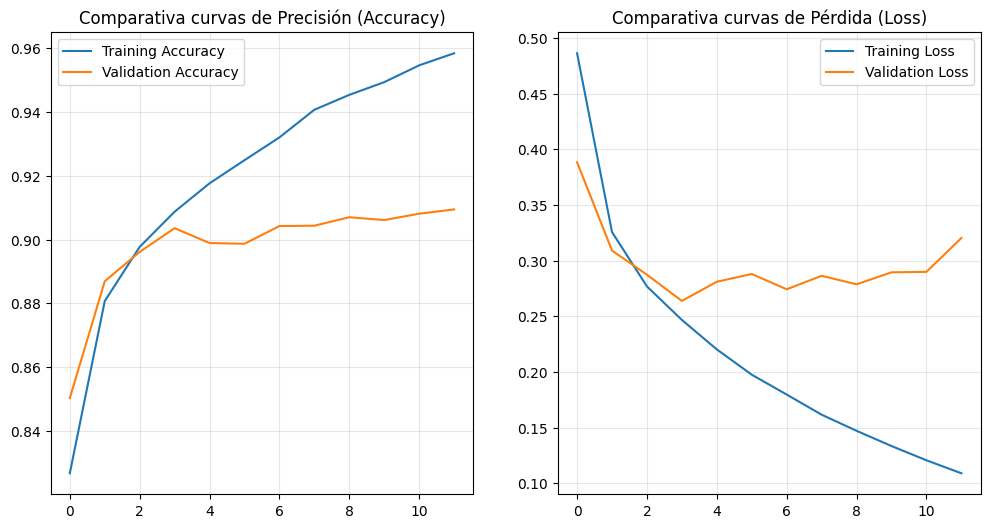

In [ ]:
# 7. Visualizacion de las curvas de aprendizaje

import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
# Gráfica 1: Loss
plt.subplot(1, 2, 2) #dividimos el area de la figura en cuadricula para dibujar las curvas
plt.plot(history.history['loss'], label='Training Loss') #nos saca la curva de perdida en entrenamiento
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Comparativa curvas de Pérdida (Loss)')
plt.legend()
plt.grid(True, alpha=0.3)


# Gráfica 2: Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Comparativa curvas de Precisión (Accuracy)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Para confirmar el análisis del rendimiento del modelo, graficamos las curvas de aprendizaje de precisión y pérdida.

Podemos confirmar que ha ocurrido Overfitting observando el comportamiento entre las curvas:
- Entrenamiento (azul): la curva de pérdida baja de forma suave y constante porque ve los datos muchas veces, logrando una precisión muy alta en la última época.
- Validación (naranja): inicialmente mejora como en el entrenamiento, pero en la época 4 consigue el mejor rendimiento (pérdida mínima). A partir de aquí, la función de pérdida comienza a subir de forma progresiva y la precisión se estanca.

Esta divergencia nos confirma el Overfitting detectado en la celda anterior y podemos afirmar que el modelo ha dejado de generalizar y ha memorizado el ruido.

Esto ha ocurrido porque hemos entrenado una CNN pequeña sin regularización, por lo que vamos a llevar a cabo dos nuevos modelos para poder comparar: una CNN con Dropout y una CNN con EarlyStopping.

In [ ]:
# 8. Entrenamiento de modelos con Dropout

from tensorflow.keras import callbacks

# Definimos una función para la arquitectura base
def create_model(use_dropout=False):
    model = models.Sequential([
        # Misma arquitectura base
        layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
    ])

    # Añadimos Dropout solo si el interruptor está en True
    if use_dropout:
        model.add(layers.Dropout(0.5))

    # 10 porque son 10 tipos de ropa
    model.add(layers.Dense(10, activation='softmax'))
    # -----------------------

    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Entrenamiento con Dropout
print("\n--- Entrenando Modelo con Dropout (0.5) ---")
model_dropout = create_model(use_dropout=True) # pedimos que si ponga Dropout

history_dropout = model_dropout.fit(
    ds_train,
    validation_data=ds_val,
    epochs=12,
    verbose=1
)


--- Entrenando Modelo con Dropout (0.5) ---
Epoch 1/12


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1594/1594 ━━━━━━━━━━━━━━━━━━━━ 51s 31ms/step - accuracy: 0.6654 - loss: 0.9286 - val_accuracy: 0.8527 - val_loss: 0.3996
Epoch 2/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 81s 31ms/step - accuracy: 0.8239 - loss: 0.4864 - val_accuracy: 0.8756 - val_loss: 0.3427
Epoch 3/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 49s 31ms/step - accuracy: 0.8469 - loss: 0.4160 - val_accuracy: 0.8842 - val_loss: 0.3124
Epoch 4/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - accuracy: 0.8638 - loss: 0.3780 - val_accuracy: 0.8961 - val_loss: 0.2883
Epoch 5/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.8733 - loss: 0.3519 - val_accuracy: 0.8968 - val_loss: 0.2894
Epoch 6/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 84s 30ms/step - accuracy: 0.8808 - loss: 0.3251 - val_accuracy: 0.9004 - val_loss: 0.2751
Epoch 7/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 87s 33ms/step - accuracy: 0.8897 - loss: 0.3063 - val_accuracy: 0.8986 - val_loss: 0.2739
Epoch 8/12
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 50s 31ms/step - accuracy: 0.8951 - loss: 0.29

Añadimos, en primer lugar, una regularización con Dropout que lo que hace es, durante el entrenamiento, desactivar aleatoriamente un porcentaje de neuronas en cada iteración (en nuestro caso hemos decidido el 50%), de manera que la red no dependa de un conjunto excesivamente pequeño de neuronas, previniendo así el overfitting. Así, la red debe distribuir el aprendizaje, creando características más robustas. Es importante tener en cuenta que el Dropout sólo está activo durante el entrenamiento, mientras que en validación y test la red cuenta con todas las neuronas para conseguir la mejor predicción posible.

Se selecciona la tasa de 0,5 (se desactivarán el 50% de las neuronas) debido a que es el estándar en la industria, ya que este número maximiza la regularización al generar el mayor número posible de combinaciones aleatorias de redes.

Vemos tras el entrenamiento del modelo incorporando una capa de Dropout del 50% un cambio en las métricas del modelo:
- Accuracy: en el entrenamiento la precisión final ha bajado del 95% al 91%, lo cual es positivo pues implica que la red no ha memorizado los datos como antes. La validación, por su parte, logra un 90,68% y va aumentando de forma constante, salvo en la época 8 donde se produce un leve descenso.
- Loss: vemos que la pérdida en validación ya no sube a partir de la época 4, sino que baja progresivamente y alcanza el mínimo en la época 11 con 0,2562.

Por tanto, podemos afirmar que el Overfitting ha desaparecido al regularizar con Dropout y, pese a que pueda parece que el modelo es peor por tener menos acierto en entrenamiento, es mucho más robusto pues en entrenamiento y validación tiene aciertos muy similares.

In [ ]:
# Entrenamiento con Early Stopping ---
print("\n--- Entrenando Modelo con Early Stopping (Paciencia=3) ---")
model_es = create_model(use_dropout=False) # Aquí pedimos que NO ponga Dropout

early_stop = callbacks.EarlyStopping(
    monitor='val_loss', # vigilamos la pérdida en validacion
    patience=3, # esperamos 3 épocas de margen
    restore_best_weights=True # al acabar volvemos a la mejor época
)

history_es = model_es.fit(
    ds_train,
    validation_data=ds_val,
    epochs=15,
    callbacks=[early_stop],
    verbose=1
)


--- Entrenando Modelo con Early Stopping (Paciencia=3) ---
Epoch 1/15
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 53s 32ms/step - accuracy: 0.7593 - loss: 0.6749 - val_accuracy: 0.8671 - val_loss: 0.3680
Epoch 2/15
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 53s 33ms/step - accuracy: 0.8758 - loss: 0.3426 - val_accuracy: 0.8941 - val_loss: 0.3019
Epoch 3/15
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 83s 34ms/step - accuracy: 0.8953 - loss: 0.2851 - val_accuracy: 0.8927 - val_loss: 0.2932
Epoch 4/15
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 52s 33ms/step - accuracy: 0.9090 - loss: 0.2505 - val_accuracy: 0.8941 - val_loss: 0.2984
Epoch 5/15
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 80s 31ms/step - accuracy: 0.9170 - loss: 0.2231 - val_accuracy: 0.8992 - val_loss: 0.2845
Epoch 6/15
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 46s 29ms/step - accuracy: 0.9266 - loss: 0.2020 - val_accuracy: 0.8981 - val_loss: 0.2899
Epoch 7/15
1594/1594 ━━━━━━━━━━━━━━━━━━━━ 45s 28ms/step - accuracy: 0.9333 - loss: 0.1787 - val_accuracy: 0.9019 - val_loss: 0.2739
Epoch 8/15
1594/

La siguiente regularización que estudiaremos en nuestro dataset es el Early Stopping que es una técnica que implica interrumpir el proceso de entrenamiento cuando el rendimiento del modelo en el conjunto de datos de validación comienza a deteriorarse.

La métrica que vamos a monitorizar es validation loss, le daremos 3 épocas de margen de error al modelo después de que empiece a empeorar y pondremos 15 epochs como límite máximo.

El modelo ha dejado de entrenarse en la época 8, debido a que la paciencia se agotó en esa, ya que la mejor época fue la 8 y después estuvo 3 épocas más empeorando. No obstante, aunque haya acabado en la 11, la variable tiene los pesos de la época 8 gracias a: restore_best_weights=True.

Las diferencias en las métricas del modelo con respecto al original considerando que la época 8 es la final, pues es con la que nos quedaremos por ser la mejor, son las siguientes:
- Accuracy: en el entrenamiento la precisión final es del 93,33% que sigue siendo más baja que la original, lo cual es positivo pues implica que la red no ha memorizado los datos como antes. La validación, por su parte, logra un 90,19% y va aumentando de forma constante hasta llegar a la época 8.
- Loss: vemos que la pérdida en validación disminuye progresivamente hasta conseguir el mejor resultado en la época 8 con un 0,2739.

Por tanto, esta técnica de regularización nos deja el modelo optimizado en la época exacta antes de empezar a degradarse los resultados con la pérdida mínima y una precisión de validación del 90,19%

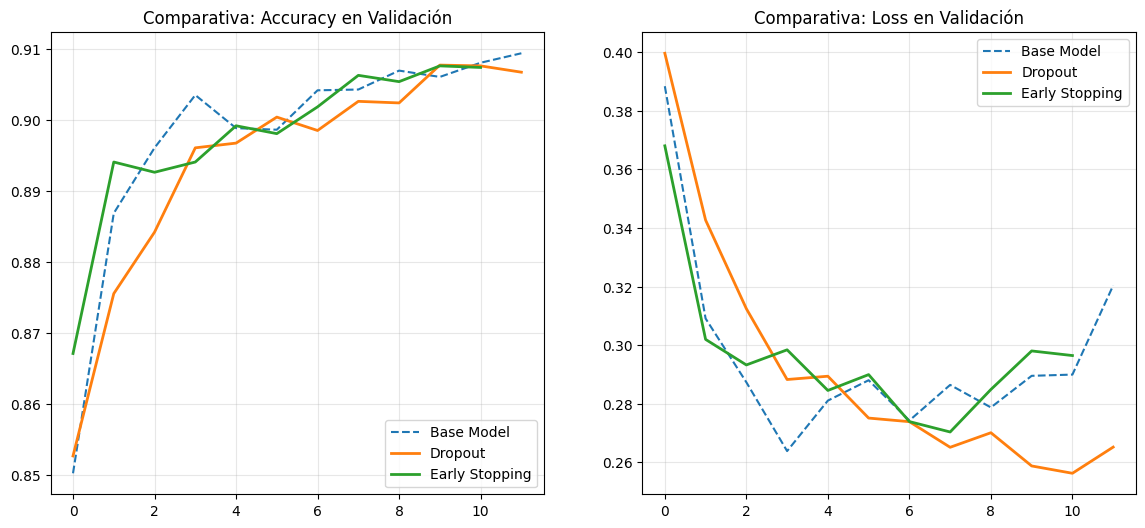

In [ ]:
# 9. Comparativa de modelos
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))


# Gráfica 1: Loss
plt.subplot(1, 2, 2)
# Modelo Base
plt.plot(history.history['val_loss'], label='Base Model', linestyle='--')
# Modelo Dropout
plt.plot(history_dropout.history['val_loss'], label='Dropout', linewidth=2)
# Modelo Early Stopping
plt.plot(history_es.history['val_loss'], label='Early Stopping', linewidth=2)

plt.title('Comparativa: Loss en Validación')
plt.legend()
plt.grid(True, alpha=0.3)


#  GRÁFICA 2: Accuracy
plt.subplot(1, 2, 1)
# Modelo Base
plt.plot(history.history['val_accuracy'], label='Base Model', linestyle='--')
# Modelo Dropout
plt.plot(history_dropout.history['val_accuracy'], label='Dropout', linewidth=2)
# Modelo Early Stopping
plt.plot(history_es.history['val_accuracy'], label='Early Stopping', linewidth=2)

plt.title('Comparativa: Accuracy en Validación')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

Podemos observar en estas gráficas un resumen del rendimiento de los tres modelos tanto en Accuracy como en Loss en el dataset de validación.

Descartamos el modelo original porque la pérdida en validación crece a partir de la época 4 y no generaliza, sino que ha memorizado los datos produciéndose Overfitting.

En cuanto a los modelos con Dropout y Early Stopping, el Accuracy en validación es ligeramente superior el de Dropout (90,68% frente a 90,19%) y la pérdida en validación es más estable, pues podemos ver que desciende de forma constante mientras que en la de Early Stopping existen algunas oscilaciones antes de la época 8.

Además, el haber entrenado desactivando neuronas nos da más confianza de que podrá funcionar mejor con los datos de test, ya que ha generalizado de forma robusta.

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step


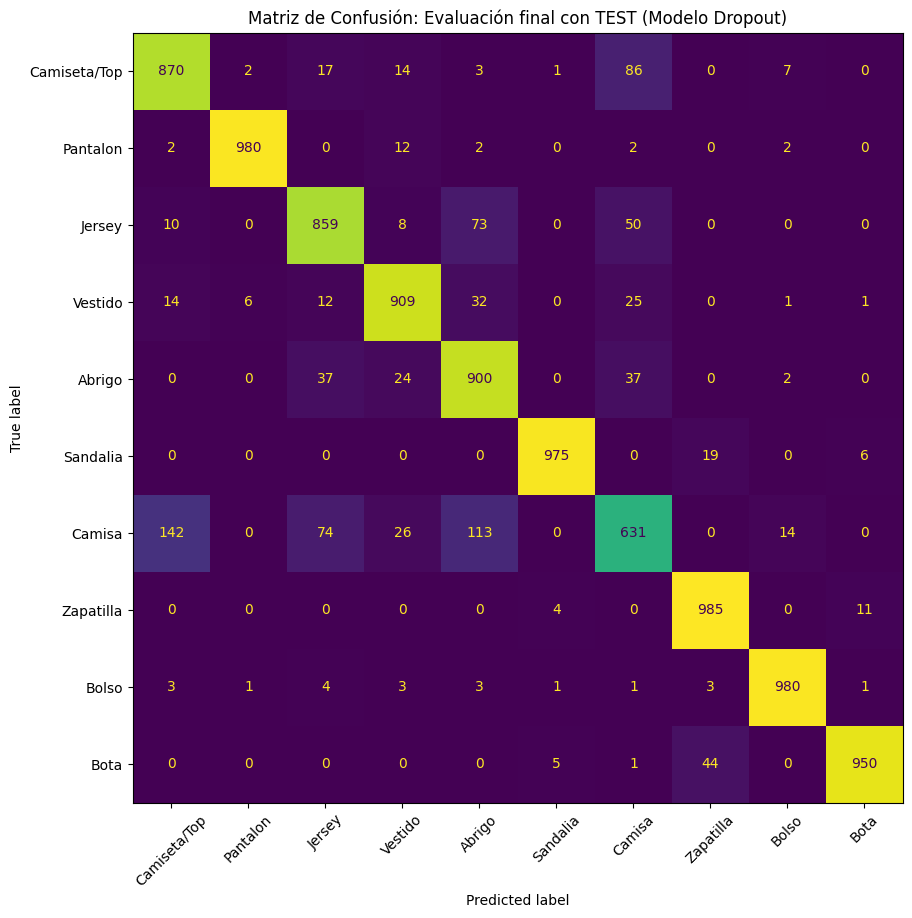

In [ ]:
# 10. Evaluación final y Matriz de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Obtenemos las predicciones sobre el Test Set usando model_dropout
y_probs = model_dropout.predict(ds_test)

# Guardamos el array resultante de todas las predicciones
y_pred = np.argmax(y_probs, axis=1)

# Usamos concatenate para upara iterar sobre el dataset de test
y_true = np.concatenate([y for x, y in ds_test], axis=0)

# Generamos la Matriz de Confusión
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(10,10))
disp.plot(xticks_rotation=45, ax=ax, cmap='viridis', values_format='d', colorbar=False)
plt.title("Matriz de Confusión: Evaluación final con TEST (Modelo Dropout)")
plt.show()

Tras evaluar a nuestro modelo con el conjunto de test, podemos examinar los resultados de la matriz de confusión. En la diagonal principal podemos ver los aciertos del modelo, donde en general son números muy altos y colores claros.

Podemos ver que el modelo es muy robusto identificando prendas que tienen siluetas muy diferentes como pantalón, bolso y zapatilla, es decir, imágenes que tienen formas geométricas claras.

Los errores más llamativos del modelo son en prendas superiores, concretamente en las clases Camiseta/Top, Jersey, Abrigo y Camisa, que se confunden entre sí.

La categoría con menor acierto es "Camisa" (sólo 631 aciertos), la cual confunde principalmente con "Camiseta/Top", con "Abrigo" y con "Jersey" en menor lugar.

Esto puede deberse a la baja resolución del dataset, que puede hacer que los detalles necesarios para clasificar prendas como la camisa se pierdan (por ejemplo, los botones) y se confundan con otras prendas superiores.

Por tanto, el modelo generaliza de forma muy precisa seis de las diez clases de ropa y sus fallos se centran en prendas que se confunden debido a la limitación de la resolución.

## PARTE 2: "Prototipo Avanzado con YOLO y Demo Creativa" (RAAC + RAAR)

Tras el éxito del prototipo inicial basado en CNN, continuaremos a la siguiente fase del proyecto en la que tenemos que detectar dentro de la imagen y funcionar a tiempo real, no solo clasificar la prenda.

Para ello utilizaremos YOLO, concretamente Yolov8, que es un algoritmo especialista en detección de objetos de forma veloz y precisa.

Utilizarmeos las imágenes (x_test) y las clases (class_names) para alimentar YOLO.

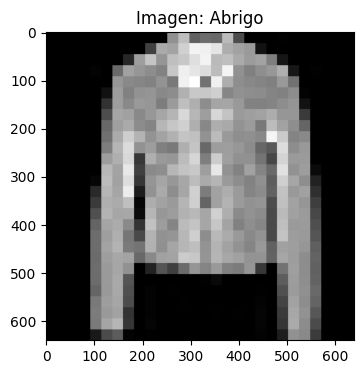

In [7]:
import cv2
from PIL import Image

# Seleccionamos una imagen del Test Set para el experimento
index = 10
img_original = x_test[index]
label_original = class_names[y_test[index]]

# Tenemos que redimensionar la imagen porque YOLO espera imágenes grandes y de 3 canales

# Deshacemos la normalización de las imágenes (volvemos a 0-255)
img_uint8 = (img_original * 255).astype(np.uint8)

# Redimensionamos de 28x28 a 640x640 para que YOLO procese las imágenes mejor
img_resized = cv2.resize(img_uint8, (640, 640), interpolation=cv2.INTER_NEAREST)

# Convertimos de Grises a RGB
img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_GRAY2RGB)

# Guardamos la imagen
filename = "prueba_yolo.jpg"
cv2.imwrite(filename, img_rgb)

# Immagen que le pasaremos a YOLO
plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.title(f"Imagen: {label_original}")
plt.show()

In [2]:
# Instalamos la librería de YOLO
!pip install ultralytics

from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.1 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [8]:
# Cargamos el modelo YOLOv8 pre-entrenado
model = YOLO('yolov8n.pt')

# Ejecutamos la inferencia - Predicción
# umbral de confianza de 0.25
results = model.predict(source="prueba_yolo.jpg", conf=0.25, save=False, verbose=False)

result = results[0]

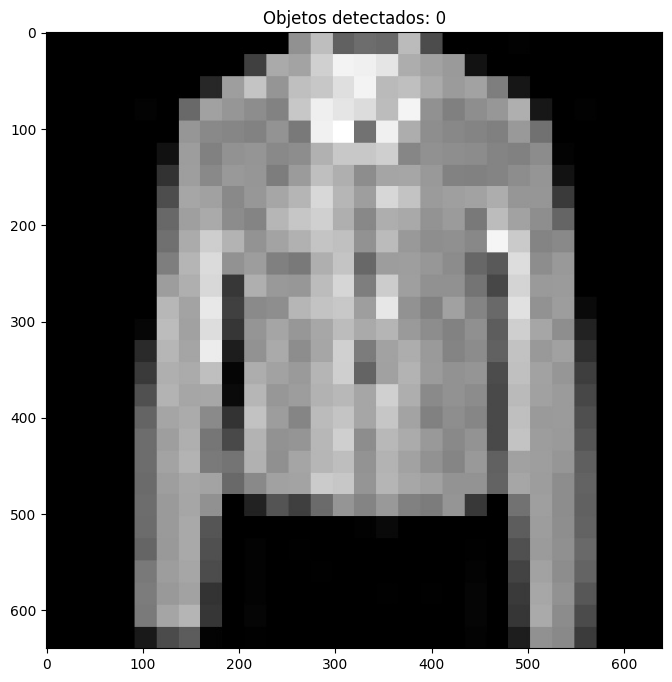

No se han detectado objetos


In [9]:
# nos devuelve la imagen con las cajas ya pintadas
img_con_cajas = result.plot()

# Convertimos de BGR (formato OpenCV) a RGB (formato Matplotlib)
img_con_cajas_rgb = cv2.cvtColor(img_con_cajas, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_con_cajas_rgb)
plt.title(f"Objetos detectados: {len(result.boxes)}")
plt.show()

if len(result.boxes) == 0:
    print("No se han detectado objetos")
else:
    for i, box in enumerate(result.boxes):
        # Coordenadas de la caja
        coords = box.xyxy[0].cpu().numpy()
        coords = [int(x) for x in coords]

        # Confianza (0 a 1)
        conf = float(box.conf)

        # Clase detectada
        cls_id = int(box.cls)
        cls_name = result.names[cls_id]

        print(f"Objeto #{i+1}:")
        print(f"   - Clase: '{cls_name}'")
        print(f"   - Confianza: {conf:.2%}")
        print(f"   - Coordenadas (Bbox): {coords}")

El modelo pre-entrenado yolov8n.pt no ha sido capaz de detectar nada en la imagen, pero esto no ha sido un error de código, sino de incompatibilidad.

YOLO es un algoritmo que funciona detectando objetos en imágenes a color y con alta resolución. Nuestra imagen es de 28x28, la hemos escalado a 640x640 y es muy borrosa, difícilmente de detectar para un algoritmo como YOLO que se ha entrenado con fotos reales y no en blanco y negro.

Además, YOLO intenta buscar el objeto, pues está pre-entrenado para detección, mientras que en nuestra imagen el objeto es la imagen completa confundiendo así al modelo que estamos usando.

Para este problema con baja resolución, nuestra CNN de clasificación es más efectiva que un algoritmo pre-entrenamo para detección.

Vamos a porbar a utilizar un modelo de YOLO pre-entrenado como clasificador, concretamente yolov8n-cls.pt.


image 1/1 /content/prueba_yolo.jpg: 224x224 crossword_puzzle 0.15, shower_curtain 0.11, refrigerator 0.05, wardrobe 0.04, envelope 0.02, 39.9ms
Speed: 22.1ms preprocess, 39.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
YOLO predice: 'crossword_puzzle'
Confianza: 15.37%


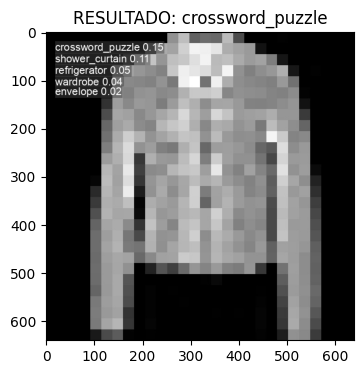

In [ ]:
# Utilizamos el modelo de YOLO como clasificador
model_cls = YOLO('yolov8n-cls.pt')

results_cls = model_cls('prueba_yolo.jpg')

# El resultado nos da las top-5 probabilidades
for result in results_cls:
    probs = result.probs
    top1 = probs.top1
    print(f"YOLO predice: '{result.names[top1]}'")
    print(f"Confianza: {probs.top1conf.item():.2%}")

    # Mostramos la imagen para comprobar
    res_plotted = result.plot()
    res_rgb = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(4,4))
    plt.imshow(res_rgb)
    plt.title(f"RESULTADO: {result.names[top1]}")
    plt.show()

Tras ejecutar el modelo de YOLO clasificador, ha predicho que nuestra imagen es un crucigrama (crossword_puzzle) con una confianza muy baja, del 15,37% (no genera bounding boxes ni coordenadas porque sirve como clasificador, no detector). Este resultado confirma que YOLO es incompatible con nuestro problema, ya que YOLO ha sido pre-entrenado con objetos del dataset ImageNet que es un dataset de fotos de alta resolución, mientras que nuestra CNN ha sido entrenada con las 10 clases de Fashion-MNIST. Esto hace que la CNN sea mucho más efectiva que YOLO, ya que ha sido diseñada para clasificar nuestra base de datos.

El resultado del modelo no es tan raro, puesto que nuestra imagen es una cuadrícula de píxeles en blanco y negro sobre un fondo negro y el modelo ha confundido la estructura de nuestra prenda con un tablero de un crucigrama.

Para que YOLO funcionase en nuestro proyecto no podemos usarlo pre-entrenado, sino que deberíamos re-entrenarlo con nuestras 10 clases específicas de ropa para poder usarlo como clasificador puro.

Por tanto, como los modelos YOLO preentrenados están optimizados para clases genéricas en vez de para piezas industriales, vamos a probar el funcionamiento de YOLO como sistema de detección general. En un entorno real, debemos reentrenar al modelo con imágenes del dominio industrial.

In [1]:
from google.colab import files

uploaded = files.upload()

Saving prueba_coche.jpg to prueba_coche.jpg


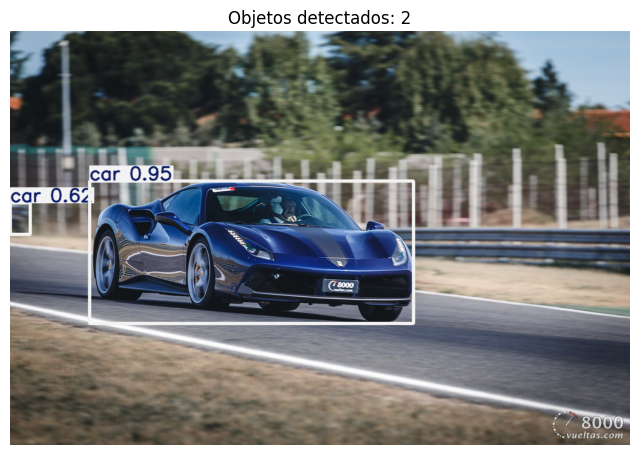

In [10]:
image_path = list(uploaded.keys())[0]

results_nueva = model.predict(
    source=image_path,
    conf=0.4,
    save=False,
    verbose=False
)

result_nueva = results_nueva[0]
img_con_cajas_nueva = result_nueva.plot()

# Convertimos de BGR a RGB
img_con_cajas_rgb_nueva = cv2.cvtColor(img_con_cajas_nueva, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 8))
plt.imshow(img_con_cajas_rgb_nueva)
plt.title(f"Objetos detectados: {len(result_nueva.boxes)}")
plt.axis("off")
plt.show()

In [11]:
if len(result_nueva.boxes) == 0:
    print("No se han detectado objetos")
else:
    for i, box in enumerate(result_nueva.boxes):
        # Coordenadas de la bounding box
        coords = box.xyxy[0].cpu().numpy().astype(int).tolist()

        # Confianza
        conf = float(box.conf[0])

        # Clase detectada
        cls_id = int(box.cls[0])
        cls_name = result_nueva.names[cls_id]

        print(f"Objeto #{i+1}:")
        print(f"   - Clase: '{cls_name}'")
        print(f"   - Confianza: {conf:.2%}")
        print(f"   - Coordenadas (Bbox): {coords}")

Objeto #1:
   - Clase: 'car'
   - Confianza: 94.66%
   - Coordenadas (Bbox): [131, 247, 666, 482]
Objeto #2:
   - Clase: 'car'
   - Confianza: 62.06%
   - Coordenadas (Bbox): [0, 283, 33, 335]


Tras observar el funcionamiento de YOLO en una imagen real como un coche, hemos visto su capacidad para detectar múltiples objetos en una sola imagen. Vemos que en la primera imagen detecta que es un coche con una confianza muy alta (94,66%), mientras que intuye un segundo vehículo pequeño al final de la imagen con una confianza mucho menor (62,06%), lo cual es un resultado coherente. Además, YOLO nos proporciona las coordenadas  en las que se encuentra el objeto en la imagen, lo cual es clave para localizar objetos en un entorno industrial y pasar esta información a brazos robóticos.

### CNN VS YOLO EN DETECCION INDUSTRIAL

Pese a que YOLO no ha funcionado en nuestro objetivo de clasificación debido a la baja resolución e incompatibilidad, en arquitectura es superior a la CNN y más eficaz para el objetivo de detección en tiempo real del cliente tal y como hemos podido comprobar con una imagen de alta resolución  general como la de los coches.

La CNN no sirve para detectar objetos, sino para clasificar imágenes según catgeorías con las que la hemos entrenado. YOLO, por su parte, está entrenado para detectar objeto y nos da tanto la clase con un vector de coordenadas (x, y, ancho, alto) que nos indica dónde está el objeto.

YOLO es mucho más eficiente que una CNN computacionalmente hablando porque no tiene que analizar la imagen miles de veces cada región, sino que la divide en una cuadrícula y predice las cajas y probabilidades.

Esto lo hemos comporbado en la imagen del coche anterior donde ha detectado dos objetos con su valor de confianza y datos de localización espacial mediante bounding boxes, lo cual permite identificar simultáneamente varios objetos en una misma imagen. Este enfoque de YOLO permite:
- Detectar múltiples objetos en una sola imagen.
- Obtener resultados en tiempo real.
- Escalar el sistema a aplicaciones industriales.

Por tanto, YOLO es el sistema ideal reentrenado con imágenes de la fábrica para poder detectar objetos en tiempo real y automatizar procesos de fabricación.

### Demo interactiva

Para llevar a cabo la demo interactiva, hemos cambiado el índice al 2 que hace referencia a un pantalón y la confianza probada ha sido del 0,25 y del 0,05, no obstante, bajar la confianza no nos ha devuelto un resultado diferente.

El modelo detector no ha sido capaz de detectar objetos como nos ocurrió en la imagen del abrigo y es por el mismo motivo.

El modelo clasificador, por su parte, ha detectado una regla con una confianza del 8,8% (una confianza baja, lo cual tiene sentido porque el modelo no está seguro). Este resultado es coherente, ya que el pantalón ampliado son dos líneas largas y rectas que se ve pixelado en los bordes como si fuesen dientes. La IA ha confundido estos "dientes" de los píxeles con las rayitas de los centimetros de la regla y su forma larga y recta coincide con la regla.

Por tanto, es una prueba más de que no podemos usar modelos entrenados con fotos de alta resolución con imágenes de baja resolución.

A pesar de este resultado, la recomendación para nuestro caso de uso sigue siendo utilizar YOLO detector, pero con imágenes de alta resolución. YOLO nos dice dónde está el objeto, lo cual sirve en la fábrica para que los brazos robóticos puedan localizar la prenda y cogerla de forma autónoma, mientras que  nuestra CNN simplemente nos clasificaría el objeto.

Esto tiene implicaciones éticas, ya que un sistema de detección preciso reducirá la necesidad de operario en la fábrica, aunque también elimina los errores humanos. La estrategia debería ser un cambio gradual en el que a los operarios se les reubique supervisando el modelo y poco a poco se vaya confiando más en los resultados del modelo, pero proablemente la consecuencia final sea el despido de un porcentaje de operarios.
